# In this notebook we plan paths for multiple agents on the hybrid graph and animate the result.

In [1]:
import sys
sys.path.append('../../')
from panav.env import NavigationEnv, Box2DRegion, box_2d_center
from panav.hybrid import HybridGraph
from panav.viz import draw_env,draw_hybrid

import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
def flowtime(plan):
    return np.sum([t[-1] for t,x in plan])

## Single-tunnel environment

In [11]:


# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 6,-6
start_x_offset = 7
goal_x_offset = 9
N = 4

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]
limits = [(-10.0,10.0),(-10.0,10.0)]


# O1 = Box2DRegion((-5.0,-0.5),(0.5,10))
# O2 = Box2DRegion((-0.0,5.0),(-10,-1.0))
# env = NavigationEnv(limits,[O1,O2],starts,goals)


O1 = Box2DRegion((-2.5,2.5),(0.5,10))
# O1 = Box2DRegion((-2.5,2.5),(2.0,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))
env = NavigationEnv(limits,[O1,O2],starts,goals)


# O1 = Box2DRegion((-2.5,2.5),(0.5,10))
# O2 = Box2DRegion((-2.5,2.5),(-3,-1.0))
# O3 = Box2DRegion((-2.5,2.5),(-10.0,-4.0))
# env = NavigationEnv(limits,[O1,O2,O3],starts,goals)


# Construct the hybrid graph representation of the environment
bloating_r = 0.5 
HG =  HybridGraph(env,bloating_r,K = 4)


/Users/tianpengzhang/opt/miniconda3/envs/PA-Nav/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


KeyError: 'continuous_path'

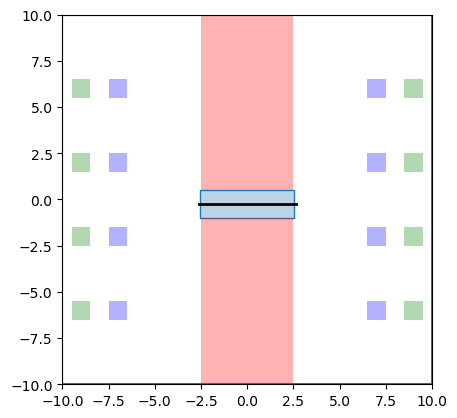

In [12]:
ax = plt.gca()
draw_hybrid(HG,ax)
plt.show()    

In [13]:
from panav.HybridSIPP import HybridSIPP
from panav.SIPP import plan_to_transitions
from time import time

while True:
    agents = np.arange(len(start_locs))
    graph_plans = []
    continuous_plans = []

    success = True
    times = []
    t0 = time()
    for a in agents:
        print(a)
        result = HybridSIPP(HG,HG.start_nodes[a],HG.goal_nodes[a],graph_plans,continuous_plans)
        if result is not None:
            gp,cp = result
        else:
            print("Solver failed. Retrying...")
            success=False
            break
        graph_plans.append(gp)
        continuous_plans.append(cp)
        times.append(time()-t0)
    if success:
        print("Solution success")
        break

0
1
2
3
4
5
6
7
Solution success


# Animate the planning process

KeyboardInterrupt: 

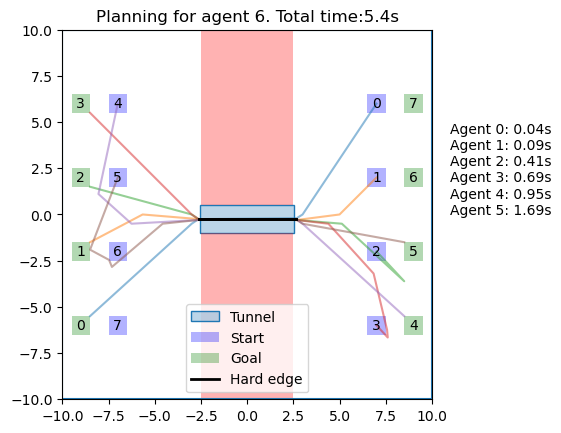

In [14]:
from matplotlib.animation import FuncAnimation
dt = 0.1 

times = np.array(times)
individual_times = times[1:]-times[:-1]

individual_times = np.hstack([times[0], individual_times])

info = ["Agent {}: {:.2f}s".format(i,individual_times[i],times[i]) for i in agents]
fig = plt.figure()
def animate(frame):
    plt.cla()
    t_now = frame * dt
    agent_finished = np.sum(np.array(times)<=t_now)
    draw_hybrid(HG,paths = [x for t,x in continuous_plans[0:agent_finished]],display_node=False,display_soft=False,show_agent_ID=True)
    
    plt.text(11,5,"\n".join(info[:agent_finished]),va='top')
    if t_now<=np.max(times):
        prestring = "Planning for agent {}.".format(agent_finished)
    else:
        prestring = "Finished."
    
    plt.title(prestring+" Total time:{:.1f}s".format(t_now))
    # plt.show()

anim = FuncAnimation(fig,animate,frames = int(np.ceil(np.max(times)/dt))+10,interval = dt*1000)
anim.save("../Figures/HybridPlanning.gif")
# display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.

In [15]:
from panav.viz import animation,interpolate_positions

from IPython.display import HTML, display
interp_dt = 0.1

pos = []
for cp in continuous_plans:
    _,xs = interpolate_positions(*cp,interp_dt)
    pos.append(xs)

anim = animation(env, pos, bloating_r, dt = interp_dt / 4)
# display(HTML(anim.to_jshtml()))
anim.save("../Figures/HybridPlanning_exec.gif")
plt.close()   # Avoid plotting an extra figure.

In [8]:
flowtime(continuous_plans)

321.01400104426

# Compare with simple tube-based planning

In [16]:
from panav.SAMP import Tube_Planning
from panav.util import unique_tx
agents = set(np.arange(len(env.starts)))

plan = []
times = []
t0 = time()
success = True
fail_time = None
for agent in agents:
    print(agent)
    
    start = env.starts[agent]
    goal = env.goals[agent]

    agent_success = False
    
    for K in [2,3,5,6,7,8]:
        print("K",K)
        results = Tube_Planning(env,start,goal,HG.vmax,bloating_r,\
                                    plan,\
                                    HG.d,K,ignore_finished_agents=False)
        if results is not None:
            t,xs = results
            times.append(time()-t0)
            print(times)
            t,xs = unique_tx(t,xs)
            plan.append((t,xs))
            agent_success = True
            break
        

    if not agent_success:
        print("Solution failed.")
        success = False
        times.append(time()-t0)
        break



0
K 2
K 3
[0.04802203178405762]
1
K 2
K 3
[0.04802203178405762, 0.11242413520812988]
2
K 2
K 3
[0.04802203178405762, 0.11242413520812988, 0.190093994140625]
3
K 2
K 3
K 5
[0.04802203178405762, 0.11242413520812988, 0.190093994140625, 0.6324410438537598]
4
K 2
K 3
K 5
[0.04802203178405762, 0.11242413520812988, 0.190093994140625, 0.6324410438537598, 1.5253798961639404]
5
K 2
K 3
K 5
[0.04802203178405762, 0.11242413520812988, 0.190093994140625, 0.6324410438537598, 1.5253798961639404, 2.531294107437134]
6
K 2
K 3
K 5
K 6
[0.04802203178405762, 0.11242413520812988, 0.190093994140625, 0.6324410438537598, 1.5253798961639404, 2.531294107437134, 5.715034008026123]
7
K 2
K 3
K 5
K 6
K 7
K 8
[0.04802203178405762, 0.11242413520812988, 0.190093994140625, 0.6324410438537598, 1.5253798961639404, 2.531294107437134, 5.715034008026123, 41.15342617034912]


In [10]:
from matplotlib.animation import FuncAnimation
dt = 0.1 

times = np.array(times)
individual_times = times[1:]-times[:-1]

individual_times = np.hstack([times[0], individual_times])

info = ["Agent {}: {:.2f}s".format(i,individual_times[i],times[i]) for i in range(len(times))]
fig = plt.figure()
def animate(frame):
    plt.cla()
    t_now = frame * dt
    agent_finished = np.sum(np.array(times)<=t_now)
    draw_env(HG.env,paths = [x for t,x in plan[0:agent_finished]],show_agent_ID=True)
    
    plt.text(11,5,"\n".join(info[:agent_finished]),va='top')
    if t_now<=np.max(times):
        prestring = "Planning for agent {}.".format(agent_finished)
    else:
        prestring = "Finished." if success else "Not finished."
    
    plt.title(prestring+" Total time:{:.1f}s".format(t_now))
    # plt.show()

anim = FuncAnimation(fig,animate,frames = int(np.ceil(np.max(times)/dt))+10,interval = dt*1000)
anim.save("../Figures/OriginalPlanning.gif")
# display(HTML(anim.to_jshtml()))
plt.close()   # Avoid plotting an extra figure.